# Correction DM3 (François Portier et Joseph Salmon)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns

from sklearn.linear_model.base import LinearModel, LinearRegression
from sklearn.base import RegressorMixin
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from scipy.optimize import minimize

# Datasets import:
import statsmodels.datasets as sd
from sklearn import datasets

%matplotlib notebook

# Plot initialization

In [2]:
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
params = {'axes.labelsize': 12,
          'font.size': 12,
          'legend.fontsize': 12,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': True,
          'figure.figsize': (8, 6)}
plt.rcParams.update(params)
plt.close("all")

sns.set_palette("colorblind")
sns.axes_style()
sns.set_style({'legend.frameon': True})
color_blind_list = sns.color_palette("colorblind", 8)
my_orange = color_blind_list[2]
my_green = color_blind_list[1]
my_blue = color_blind_list[0]
my_purple = color_blind_list[3]

In [3]:
plt.close("all")

# EXERCISE 1 Régression robuste

# Q1: Simulation des données

Générer $n=100$ vecteurs aléatoires $(y_i,x_i)$ selon le modèle précédent avec $d = 2$, $\boldsymbol\theta = (1,1)^\top$, $\theta_0 = 1$ et $\varepsilon_i$ gaussien de moyenne $0$ et variance $1$.

In [4]:
np.random.seed(1)  # Seed intialization.
n = 100
d = 2

X = np.random.uniform(0, 1, [n, d])
epsilon = np.random.normal(0, 1, n)
theta = np.ones(d + 1)

Xtilde = np.c_[X, np.ones(n)]
Y = np.dot(Xtilde, theta) + epsilon

***Remarque pour les correcteurs ***: Les jeux de données étant simulés, ils sont différents d'une session à l'autre. Les résultats obtenus peuvent donc différer (marginalement), d'une session à l'autre.

# Q2: Visualisation
Sur un même graphique, dont l'abscisse minimal et maximal seraient $-5$ et $+5$, tracer $\rho_\alpha$ pour $\alpha =  .5,2,5$. Décrire l'effet de alpha sur l'estimation de $\hat{\boldsymbol\theta}_\alpha$.

<IPython.core.display.Javascript object>


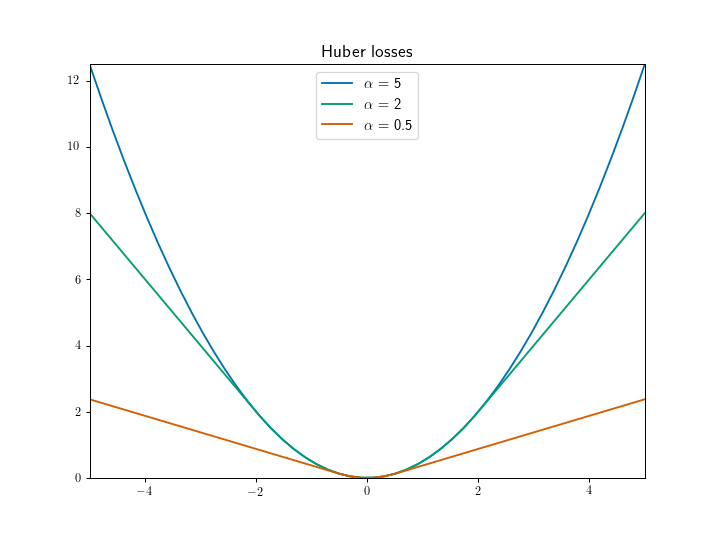

In [5]:
def rho(x):
    """ loss function"""
    z = np.abs(x)
    y = np.zeros(x.shape)
    if (alpha > 0):
        y[np.abs(x) <= alpha] = x[np.abs(x) <= alpha]**2 / 2
        y[np.abs(x) > alpha] = alpha * np.abs(x[z > alpha]) - alpha**2 / 2
    else:
        y = z
    return y


xs = np.linspace(-5, 5)
alpha_value = [5, 2, .5]
fig = plt.figure()
plt.axis([-5, 5, 0, 5**2 / 2])
for index, alpha in enumerate(alpha_value):
    plt.plot(xs, rho(xs), '-', label='$\\alpha = $ ' +
             str(alpha), markersize=4)
plt.title('Huber losses')
plt.legend(loc='upper center')
plt.show()

Le paramêtre $\alpha$ joue sur les résidus ayant de grandes valeurs : les ''outliers''. Un $\alpha$ très grand correspond à la regréssion
des moindres carrées, qui a tendance à attribuer beaucoup de poids à ces ''outliers''. Un $\alpha$ très petit
correpsond à la régression médiane qui est plus robuste aux grandes valeurs des résidus. Selon la distribution du jeu de données, il faut choisir $\alpha$ convenablement.

# Q3: Pour $\alpha = 2$, calculer $\hat{\boldsymbol\theta}_\alpha$.
On pourra importer ''minimize''  de scipy.optimize et utiliser le code minimize(f, init, method='nelder-mead',options={'xtol': 1e-5}) où f est la fonction (de plusieurs variables) à minimiser et ''init'' est le point de départ de la méthode (dans l'espace de définition de f, par exemple $(0,0,0)$). Dans la suite on va considérer d'autres valeurs de $\alpha$, on pourra donc rédiger son code de façon à faciliter ce changement.

In [6]:
def risque_emp(theta):
    """ Emprical risk evaluation """
    residual = Y - np.dot(Xtilde, theta)
    return np.sum(rho(residual))


alpha = 2
res = minimize(risque_emp, [0] * (d + 1), method='nelder-mead',
               options={'xtol': 1e-3})

theta_chap_2 = res.x
pred = np.dot(Xtilde, theta_chap_2)

print("Pour alpha = 2, l'estimateur vaut", theta_chap_2)

Pour alpha = 2, l'estimateur vaut [ 0.80121376  1.26405314  1.04145807]


# Q4: Un bootstrap de $\hat{\boldsymbol\theta}_\alpha$
 En utilisant le bootstrap des résidus, calculer un estimateur bootstrap $\hat{\boldsymbol\theta}_\alpha^*$ pour $\alpha = 2$.


In [7]:
resid = Y - pred
resid_star = resid[np.random.randint(n, size=n)]
Y_star = pred + resid_star


def risque_boot(theta):
    """ boostrap risk evaluation"""
    eps_theta = Y_star - np.dot(Xtilde, theta)
    return np.sum(rho(eps_theta))


theta_star = minimize(risque_boot, theta_chap_2, method='nelder-mead',
                      options={'xtol': 1e-3}).x
print(theta_star)

[ 1.16398693  1.21714522  0.82809681]


# Q5: Plein de bootstrap
Toujours pour $\alpha = 2$, à partir de  $B=200$ réplicats d'estimateurs bootstrap $\hat{\boldsymbol\theta}_{1,\alpha}^*,\ldots , \hat{\boldsymbol\theta}_{B,\alpha}^*$ (issues de la question précédente), calculer un estimateur de la matrice de variance $V_{boot}$ et un estimateur du biais $b_{boot}$ de l'estimateur $\hat{\boldsymbol\theta}_\alpha$. On calculera aussi l'estimateur de l'erreur quadratique moyenne associée à l'estimateur, donné par
\begin{align*}
\text{EQM}_{boot}(\alpha)=  \frac 1 B \sum_{b=1} ^B   \| \hat{\boldsymbol\theta}_{b,\alpha}^* - \hat{\boldsymbol\theta}_\alpha\|^2  = \| \hat{\boldsymbol\theta}_\alpha -   \overline{\hat{\boldsymbol\theta}_{\cdot,\alpha}^*}\|^2 + \frac 1 B \sum_{b=1} ^B  \| \hat{\boldsymbol\theta}_{b,\alpha}^* - \overline{\hat{\boldsymbol\theta}_{\cdot,\alpha}^*}\|^2 ,
\end{align*}
où $ \overline{\hat{\boldsymbol\theta}_{\cdot,\alpha}^*} = \frac 1 B \sum_{b=1} ^B    \hat{\boldsymbol\theta}_{b,\alpha}^*$ et $\|\cdot\|$ est la norme Euclidienne.


In [8]:
B = 200
theta_mem = np.zeros([d + 1, B])
for b in range(B):
    resid_star = resid[np.random.randint(n, size=n)]
    Y_star = pred + resid_star

    theta_mem[:, b] = minimize(risque_boot, theta_chap_2, method='nelder-mead',
                               options={'xtol': 1e-3}).x

# True: formule de la variance avec 1/N: false: 1/(N-1)
v_boot = np.cov(theta_mem, bias=True)
bias_boot = np.mean(theta_mem, axis=1) - theta_chap_2

EQM = np.sum(bias_boot ** 2) + np.trace(v_boot)
print(EQM)

0.279188716503


# Q6 EQM et conclusion

En remarquant que $\text{EQM}_{boot}(\alpha)$ est un estimateur du risque
\begin{align*}
\mathbb E [ \| \hat{\boldsymbol\theta}_\alpha - \boldsymbol\theta \|^2 ] ,
\end{align*}
proposez une procédure permettant de choisir le meilleur $\alpha$ consiste à sélectionner le $\alpha$ qui minimise $\text{EQM}_{boot}(\alpha)$. Sur une grille de $20$ points équidistants entre $0$ et $10$, tracer $\text{EQM}_{boot}(\alpha)$ pour $\alpha$ variant sur cette grille.


<IPython.core.display.Javascript object>


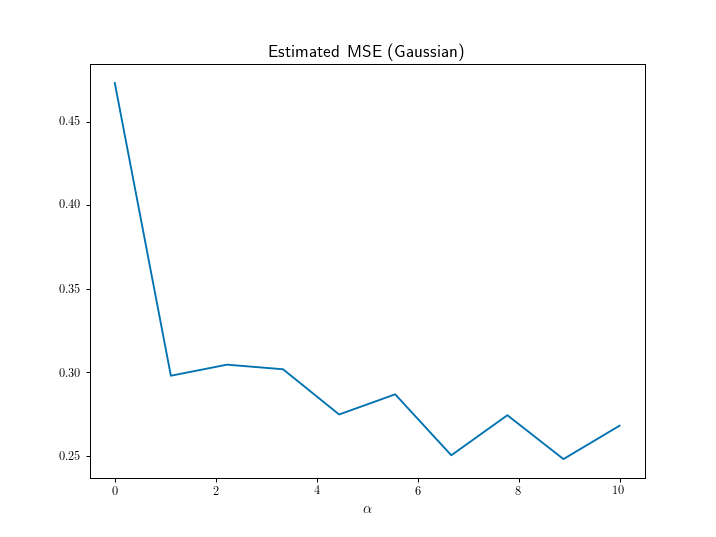

In [9]:
B = 200
grille = np.linspace(0., 10., num=10)
EQM_mem = np.zeros(grille.shape)

for index, alpha in enumerate(grille):
    theta_chap = minimize(risque_emp, [0] * (d + 1), method='nelder-mead',
                          options={'xtol': 1e-3}).x
    pred = np.dot(Xtilde, theta_chap)
    resid = Y - pred
    theta_mem = np.zeros([d + 1, B])
    for b in range(B):
        resid_star = resid[np.random.randint(n, size=n)]
        Y_star = pred + resid_star
        theta_mem[:, b] = minimize(risque_boot, theta_chap,
                                   method='nelder-mead',
                                   options={'xtol': 1e-3}).x

    v_boot = np.cov(theta_mem, bias=True)  # True formula with 1/N, not 1/(N-1)
    bias_boot = np.mean(theta_mem, axis=1) - theta_chap

    EQM_mem[index] = np.sum(bias_boot**2) + np.trace(v_boot)

# Plot / visualization
fig = plt.figure()
plt.plot(grille, EQM_mem, label='obs', markersize=4)
plt.title('Estimated MSE (Gaussian)')
ax = plt.gca()
ax.set_xlabel(r'$\alpha$')
plt.show()

***Remarque pour les correcteurs*** : La courbe obtenue a tendance à être décroissante. Mais cela peut varier un peu selon les données générées. Ces variations s'atténuent en prenant $B$ plus grand.

# Q7: Cauchy
On change maintenant la distribution des erreurs. On prend une loi standard de Cauchy (générée sous numpy par ''numpy.random.standard_cauchy(n)''). Tracer le même graphique qu'à la question précédente. Conclure.

<IPython.core.display.Javascript object>


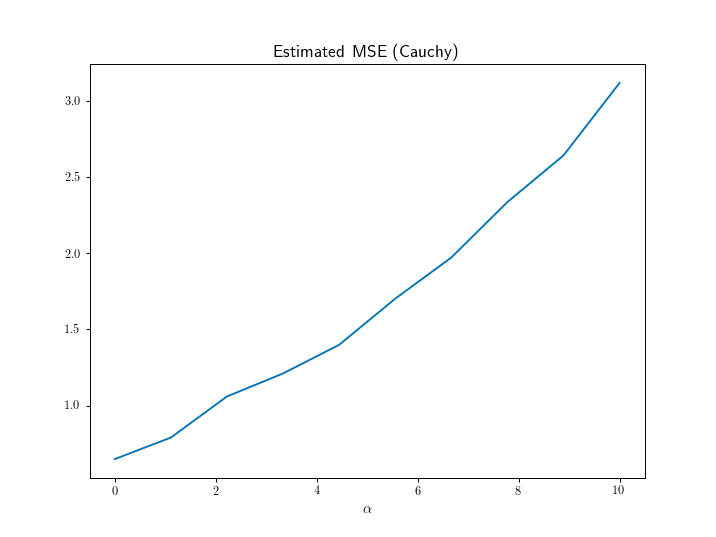

In [10]:
np.random.seed(1)  # Seed intialization.
n = 100
d = 2

X = np.random.uniform(0, 1, [n, d])
epsilon = np.random.standard_cauchy(n)
theta = np.ones(d + 1)

Xtilde = np.c_[X, np.ones(n)]
Y = np.dot(Xtilde, theta) + epsilon

B = 200
grille = np.linspace(0., 10, num=10)
EQM_mem = np.zeros(grille.shape)

for index, alpha in enumerate(grille):
    theta_chap = minimize(risque_emp, [0] * (d + 1), method='nelder-mead',
                          options={'xtol': 1e-3}).x
    pred = np.dot(Xtilde, theta_chap)
    resid = Y - pred
    theta_mem = np.zeros([d + 1, B])
    for b in range(B):
        resid_star = resid[np.random.randint(n, size=n)]
        Y_star = pred + resid_star
        theta_mem[:, b] = minimize(risque_boot, theta_chap,
                                   method='nelder-mead',
                                   options={'xtol': 1e-3}).x

    v_boot = np.cov(theta_mem, bias=True)  # True formula with 1/N, not 1/(N-1)
    bias_boot = np.mean(theta_mem, axis=1) - theta_chap

    EQM_mem[index] = np.sum(bias_boot**2) + np.trace(v_boot)

# Plot / visualization
fig = plt.figure()
plt.plot(grille, EQM_mem, label='obs', markersize=4)
plt.title('Estimated MSE (Cauchy)')
ax = plt.gca()
ax.set_xlabel(r'$\alpha$')
plt.show()

***Conclusion*** : Nous remarquons que pour des résidus Gaussien le $\alpha$ opimal déterminé par le bootstrap est grand. Dans le cas de résidus suivant une loi de Cauchy, c'est l'inverse, le $\alpha$ optimal est $0$. Ceci s'explique par l'heuristique suivante:

La loi de Cauchy, contrairement à la loi Gaussienne, est une loi dite à ''queue lourde''. C'est à dire que les réalisations d'une telle loi sont souvent grandes. Ainsi, dans ce cas, notre jeu de données comporte beaucoup de ''grands'' résidus. Il vaud donc mieux utiliser une autre fonction de perte que la fonction carrée: la perte ''absolue'' qui attribue moins de poids aux grands résidus.

# Q8: Application du bootstrap à la base "diabetese"

Charger la base ``diabetese'' de sklearn. Appliquer la méthode précédente au choix du coefficient $\alpha$ pour la régression
 de $y$ sur la quatrième variable de la base. On veillera à bien choisir le domaine des $\alpha$ pour optimiser le $\text{EQM}_{boot}(\alpha)$.
 

In [11]:
datasets.load_diabetes()

diabetes = datasets.load_diabetes()
diabetes_X = diabetes.data
n = diabetes_X.shape[0]
Xtilde = np.c_[diabetes_X[:, [3]], np.ones(n)]
d = Xtilde.shape[1]
Y = diabetes.target
print("La dimension de la matrice Xtilde est: {0} x {1}".format(n, d))

La dimension de la matrice Xtilde est: 442 x 2


Calcul de theta chapeau pour $\alpha = 1$ (simple vérification).

In [12]:
alpha = 1
theta_chap = minimize(risque_emp, [0] * (d), method='nelder-mead',
                      options={'xtol': 1e-3}).x

print(theta_chap)

[ 890.46990316  146.97055474]


On applique le bootstrap en utilisant le code précédent. Il faut étendre le domaine de définition car les résidus sont bien plus grand que précéement. 

***Remarque pour les correcteurs*** : On prend ici $B=500$ pour plus de stabilité mais cela n'est pas nécéssaire à l'obtention de tous les points à la question.

<IPython.core.display.Javascript object>


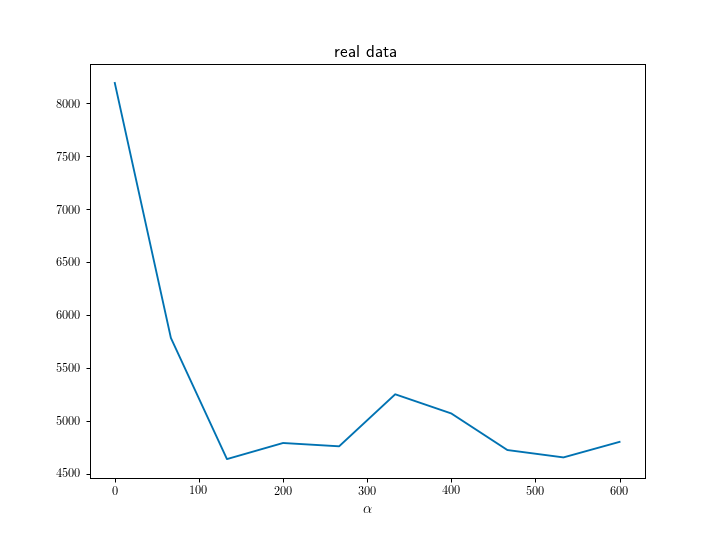

In [13]:
B = 500
grille = np.linspace(0., 600, num=10)
EQM_mem = np.zeros(grille.shape)

for index, alpha in enumerate(grille):
    theta_chap = minimize(risque_emp, [0] * d, method='nelder-mead',
                          options={'xtol': 1e-3}).x
    pred = np.dot(Xtilde, theta_chap)
    resid = Y - pred
    theta_mem = np.zeros([d, B])
    for b in range(B):
        resid_star = resid[np.random.randint(n, size=n)]
        Y_star = pred + resid_star
        theta_mem[:, b] = minimize(risque_boot, theta_chap,
                                   method='nelder-mead',
                                   options={'xtol': 1e-3}).x

    v_boot = np.cov(theta_mem, bias=True)  # True formula with 1/N, not 1/(N-1)
    bias_boot = np.mean(theta_mem, axis=1) - theta_chap

    EQM_mem[index] = np.sum(bias_boot**2) + np.trace(v_boot)

# Plot / visualization
fig = plt.figure()
plt.plot(grille, EQM_mem, label='obs', markersize=4)
plt.title('real data')
ax = plt.gca()
ax.set_xlabel(r'$\alpha$')
plt.show()

# Exercise : Greedy method

In [14]:
# Import
# could also try the following, though some pandas tricks are needed.
#
# from sklearn.datasets import fetch_mldata
# data = fetch_mldata('Air quality')

data = sd.get_rdataset('airquality').data
df = data.dropna()
df.head()

,Ozone,Solar.R,Wind,Temp,Month,Day
0,41.0,190.0,7.4,67,5,1
1,36.0,118.0,8.0,72,5,2
2,12.0,149.0,12.6,74,5,3
3,18.0,313.0,11.5,62,5,4
6,23.0,299.0,8.6,65,5,7


# Q9: standardize

In [15]:
X_df = df.drop('Ozone', 1)
columns = X_df.columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)
X_df = pd.DataFrame(X_scaled, columns=columns)
X_df.head()

,Solar.R,Wind,Temp,Month,Day
0,0.057286,-0.717078,-1.137647,-1.510938,-1.724290
1,-0.736183,-0.547665,-0.610607,-1.510938,-1.608922
2,-0.394550,0.751164,-0.399791,-1.510938,-1.493553
3,1.412796,0.440574,-1.664687,-1.510938,-1.378185
4,1.258510,-0.378253,-1.348463,-1.510938,-1.032080


# Q10: greedy method

In [16]:
X = X_df.values
y = df[['Ozone']].values  # y : Ozone

n_samples, n_features = X.shape
print(columns)

sklearn_test = True
if sklearn_test == True:
    y = y - np.mean(y)  # so that intercept should be none in the OMP model

Index(['Solar.R', 'Wind', 'Temp', 'Month', 'Day'], dtype='object')


In [17]:
def stpforward(X, y, M):
    """Orthogonal Matching Pursuit model (OMP).
    X: Array-like, shape (n_samples, n_features).
        Training data.
    y: Array-like, shape (n_samples, ).
        Target values.
    M: Integer, in [1,n_features]
    """
    selected_variables = []
    residual = y
    p = X.shape[1]
    coef_selected = np.zeros(p)
    for i in range(1, M + 1):
        tab_alphaj = np.zeros(p)
        for j in range(0, p):
            if(j not in selected_variables):
                # Compute Alphaj and add it in tab_Alphaj
                Xj = X[:, j]
                valeur_alphaj = np.abs(Xj.dot(residual))
                tab_alphaj[j] = valeur_alphaj
        jmax = np.argmax(tab_alphaj)
        selected_variables.append(jmax)
        X_selected = X[:, selected_variables]
        skl_linmod = LinearRegression(fit_intercept=False)
        skl_linmod.fit(X_selected, y)
        # Store coefficients
        coef_selected[selected_variables] = skl_linmod.coef_
        # Update residual
        y_hat = skl_linmod.predict(X_selected)[0]
        residual = y - y_hat
    return coef_selected, selected_variables

In [18]:
# Testing the formula for M=1, check that
theta, indices = stpforward(X, y, 1)
print(theta)
print(indices)
print(theta[2], np.squeeze(X[:, 2].T.dot(y) / np.linalg.norm(X[:, 2])**2))

[  0.           0.          23.13969957   0.           0.        ]
[2]
23.1396995668 23.139699566849583


# Q11: class MYOMP

In [19]:
class MYOMP(LinearModel, RegressorMixin):
    """Orthogonal Matching Pursuit model (OMP).

    Parameters
    ----------
    n_nonzero_coefs : int, optional
        Desired number of non-zero entries in the solution. If None (by
        default) this value is set to 10% of n_features.
    """

    def __init__(self, n_nonzero_coefs=None, fit_intercept=False, normalize=False, precompute='auto'):
        self.n_nonzero_coefs = n_nonzero_coefs
        self.fit_intercept = False
        self.normalize = normalize
        self.precompute = precompute

    def fit(self, X, y):
        """Fit the model using X, y as training data.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
        Training data.
        y : array-like, shape (n_samples,) or (n_samples, n_targets)
        Target values.
        Returns
        -------
        self : object
        returns an instance of self.
        """
        self.coef_ = np.zeros([X.shape[1], ])
        self.coef_, self.selected_variables = stpforward(
            X, y, self.n_nonzero_coefs)
        # MODIFY HERE !!!
        self.intercept_ = 0.
        return self

# Q11: apply MYOMP to the airquality dataset 

In [20]:
for i in range(1, 6):
    print('\n --------For M = {}", --------'.format(i))
    test_myomp = MYOMP(n_nonzero_coefs=i)
    test_myomp.fit(X, y)
    print("The selected indices are :      ", test_myomp.selected_variables)

    print("The associated coordinates are: ", test_myomp.coef_[
          test_myomp.selected_variables], " \n")

    print(test_myomp.intercept_)


 --------For M = 1", --------
The selected indices are :       [2]
The associated coordinates are:  [ 23.13969957]  

0.0

 --------For M = 2", --------
The selected indices are :       [2, 1]
The associated coordinates are:  [ 17.33790739 -11.66917173]  

0.0

 --------For M = 3", --------
The selected indices are :       [2, 1, 0]
The associated coordinates are:  [ 15.67331326 -11.80641781   5.42816683]  

0.0

 --------For M = 4", --------
The selected indices are :       [2, 1, 0, 3]
The associated coordinates are:  [ 17.7488752  -11.74591966   4.50045463  -4.38806519]  

0.0

 --------For M = 5", --------
The selected indices are :       [2, 1, 0, 3, 4]
The associated coordinates are:  [ 17.98521995 -11.75277084   4.56193076  -4.45895297   2.37393859]  

0.0


# Q12: comparison with OrthogonalMatchingPursuit

In [21]:
# CONGRATS: with fit_intercept=False, normalize=False you just find a bug in sklearn.
# but weirdly you can recover correct results using fit_intercept=True, normalize=False

for i in range(1, 6):
    print('\n --------Pour M = {}", --------'.format(i))
    omp = OrthogonalMatchingPursuit(
        n_nonzero_coefs=i, fit_intercept=True, normalize=True)
    omp.fit(X, y)
    print(omp.coef_)
    print(omp.intercept_)
    idx_r, = omp.coef_.nonzero()
    print("The selected indices are :      ", idx_r)
    print("The associated coordinates are: ", omp.coef_[idx_r], " \n")


 --------Pour M = 1", --------
[  0.           0.          23.13969957   0.           0.        ]
[  2.41801363e-15]
The selected indices are :       [2]
The associated coordinates are:  [ 23.13969957]  


 --------Pour M = 2", --------
[  0.         -11.66917173  17.33790739   0.           0.        ]
[  4.46256530e-15]
The selected indices are :       [1 2]
The associated coordinates are:  [-11.66917173  17.33790739]  


 --------Pour M = 3", --------
[  5.42816683 -11.80641781  15.67331326   0.           0.        ]
[  4.92051278e-15]
The selected indices are :       [0 1 2]
The associated coordinates are:  [  5.42816683 -11.80641781  15.67331326]  


 --------Pour M = 4", --------
[  4.50045463 -11.74591966  17.7488752   -4.38806519   0.        ]
[  6.24440281e-15]
The selected indices are :       [0 1 2 3]
The associated coordinates are:  [  4.50045463 -11.74591966  17.7488752   -4.38806519]  


 --------Pour M = 5", --------
[  4.56193076 -11.75277084  17.98521995  -4.45895297  

In [22]:
print(omp.coef_[idx_r] / n_samples)

[ 0.04109848 -0.10588082  0.16202901 -0.04017075  0.02138683]


In [23]:
print(np.squeeze(X[:, 2].T.dot(y) / np.linalg.norm(X[:, 2])**2))

23.139699566849583


***Remarque pour le correcteur***: ici comme sklearn fait des choses "étranges" selon que l'on passe ou non les arguments "fit_intercept=True, normalize=True", il est demandé d'être indulgent dans la correction.

# Q14: Learning how to use GridSearchCV 

In [24]:
from sklearn.model_selection import GridSearchCV
parameters = {"n_nonzero_coefs": [1, 2, 3, 4, 5]}
clf = MYOMP()
my_grid = GridSearchCV(clf, cv=3, param_grid=parameters,
                       scoring='neg_mean_squared_error')

In [25]:
my_grid.fit(X, y)

GridSearchCV(cv=3, error_score='raise',
       estimator=MYOMP(fit_intercept=False, n_nonzero_coefs=None, normalize=False,
   precompute='auto'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_nonzero_coefs': [1, 2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [26]:
best_size = my_grid.best_params_["n_nonzero_coefs"]
print(best_size)

5


In [27]:
my_grid.cv_results_

{'mean_fit_time': array([ 0.00067139,  0.00085203,  0.00185005,  0.00298071,  0.00409015]),
 'mean_score_time': array([ 0.00025558,  0.00017492,  0.00023985,  0.0004065 ,  0.0002559 ]),
 'mean_test_score': array([-621.9643183 , -503.63293451, -486.44486767, -453.09917845,
        -447.18106333]),
 'mean_train_score': array([-550.85091457, -450.80190386, -422.22506794, -410.2871244 ,
        -404.86268454]),
 'param_n_nonzero_coefs': masked_array(data = [1 2 3 4 5],
              mask = [False False False False False],
        fill_value = ?),
 'params': [{'n_nonzero_coefs': 1},
  {'n_nonzero_coefs': 2},
  {'n_nonzero_coefs': 3},
  {'n_nonzero_coefs': 4},
  {'n_nonzero_coefs': 5}],
 'rank_test_score': array([5, 4, 3, 2, 1], dtype=int32),
 'split0_test_score': array([-678.5414535 , -569.41326662, -588.73141482, -535.47827577,
        -530.97824475]),
 'split0_train_score': array([-548.7832641 , -433.8142547 , -390.35090561, -379.6641352 ,
        -373.16408638]),
 'split1_test_score': ar

# Q15: plotting CV errors and best parameter

In [28]:
cv_mean_test_error = -my_grid.cv_results_["mean_test_score"]
std_test_score = my_grid.cv_results_["std_test_score"]

<IPython.core.display.Javascript object>


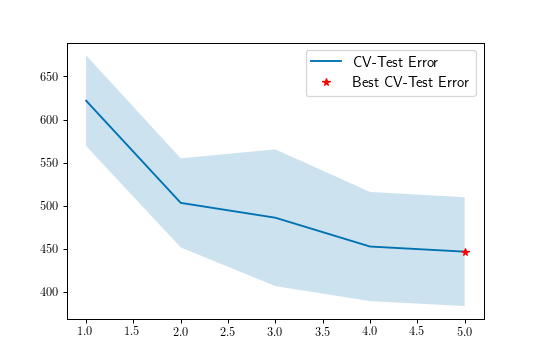

In [29]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(parameters["n_nonzero_coefs"],
        cv_mean_test_error, label="CV-Test Error")
plt.fill_between(parameters["n_nonzero_coefs"],
                 cv_mean_test_error - std_test_score,
                 cv_mean_test_error + std_test_score,
                 alpha=0.2)
ax.plot(best_size, np.min(cv_mean_test_error),
        '*', c='r', label="Best CV-Test Error")
plt.legend()
plt.show()